In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


In [3]:
sentences = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "a man is walking home",
    "she likes to play guitar",
    "the sky is blue",
    "birds fly in the sky",
    "he reads a book",
    "the child is playing",
    "music makes people happy",
    "the weather is nice today"
]


In [5]:
# simple whitespace tokenizer
tokens = [s.split() for s in sentences]

# build vocabulary
vocab = sorted({w for sent in tokens for w in sent})
stoi = {w:i+1 for i,w in enumerate(vocab)}  # start indexing from 1
stoi["<pad>"] = 0
itos = {i:w for w,i in stoi.items()}

# encode
encoded = [[stoi[w] for w in sent] for sent in tokens]
max_len = max(len(x) for x in encoded)

# pad
padded = [seq + [0]*(max_len - len(seq)) for seq in encoded]
padded = torch.tensor(padded)
print("Input token indices:\n", padded)


Input token indices:
 tensor([[30,  5, 27, 22, 30, 19],
        [30,  8,  6, 30,  5,  0],
        [ 1, 18, 15, 33, 13,  0],
        [28, 16, 31, 24, 10,  0],
        [30, 29, 15,  3,  0,  0],
        [ 2,  9, 14, 30, 29,  0],
        [12, 26,  1,  4,  0,  0],
        [30,  7, 15, 25,  0,  0],
        [20, 17, 23, 11,  0,  0],
        [30, 34, 15, 21, 32,  0]])


In [7]:
d_model = 32
vocab_size = len(stoi)

embed = nn.Embedding(vocab_size, d_model)

def sinusoidal_positional_encoding(seq_len, d_model):
    pos = torch.arange(seq_len).unsqueeze(1)
    i = torch.arange(d_model).unsqueeze(0)
    angle_rates = 1 / (10000 ** (2 * (i//2) / d_model))
    angles = pos * angle_rates

    # even → sin, odd → cos
    angles[:, 0::2] = torch.sin(angles[:, 0::2])
    angles[:, 1::2] = torch.cos(angles[:, 1::2])
    return angles

pos_encoding = sinusoidal_positional_encoding(max_len, d_model)


In [9]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    scores = Q @ K.transpose(-2, -1) / np.sqrt(Q.size(-1))

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attn_weights = torch.softmax(scores, dim=-1)
    output = attn_weights @ V
    return output, attn_weights


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=32, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch, seq, d_model = x.size()

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # split into heads
        Q = Q.view(batch, seq, self.num_heads, self.d_head).transpose(1,2)
        K = K.view(batch, seq, self.num_heads, self.d_head).transpose(1,2)
        V = V.view(batch, seq, self.num_heads, self.d_head).transpose(1,2)

        attn_outputs, attn_weights = scaled_dot_product_attention(Q, K, V)

        # concat heads
        attn_outputs = attn_outputs.transpose(1,2).reshape(batch, seq, d_model)

        return self.W_o(attn_outputs), attn_weights


In [13]:
class FeedForward(nn.Module):
    def __init__(self, d_model=32, d_ff=128):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


In [15]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model=32, num_heads=4):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        attn_out, attn_weights = self.mha(x)
        x = self.norm1(x + attn_out)      # Add & Norm
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)       # Add & Norm
        return x, attn_weights


In [17]:
# embeddings
x = embed(padded)
x = x + pos_encoding  # add positional encoding

# encoder
encoder = TransformerEncoderBlock()
contextual_embeddings, attn_weights = encoder(x)

print("\nFinal contextual embeddings:")
print(contextual_embeddings)



Final contextual embeddings:
tensor([[[ 1.6665,  1.5298,  1.0348,  ...,  1.4069, -0.3018,  2.1276],
         [ 0.7891,  0.2000,  0.5484,  ...,  0.0787, -0.0485,  0.9725],
         [-0.6432, -0.8647,  0.4856,  ..., -0.4359, -0.9229, -0.0751],
         [ 0.4779, -2.3840,  0.9406,  ...,  1.3662, -0.4260,  0.2022],
         [ 1.0582,  0.1632,  2.0237,  ...,  1.6286, -0.3093,  2.4377],
         [-1.3682, -1.3744, -0.5040,  ..., -0.3538, -0.6469,  0.9170]],

        [[ 1.6220,  1.4604,  0.8857,  ...,  1.3611, -0.3385,  2.2473],
         [-2.7717, -0.8558,  0.8276,  ..., -0.2340, -0.3436,  0.8013],
         [-1.0228, -1.8464,  1.3176,  ..., -0.4827, -0.5454, -1.1545],
         [ 1.6494, -0.2070,  1.9226,  ...,  1.5090, -0.3899,  2.4131],
         [-0.8479, -1.1818,  0.9825,  ...,  0.2818, -0.1366,  1.2863],
         [-2.4063, -1.5921,  0.4194,  ..., -0.0734,  1.1208,  0.6123]],

        [[ 0.8412,  0.2351,  0.1679,  ...,  2.2695, -0.7023, -0.1336],
         [ 0.1419, -0.1842, -1.5794,  ..., 

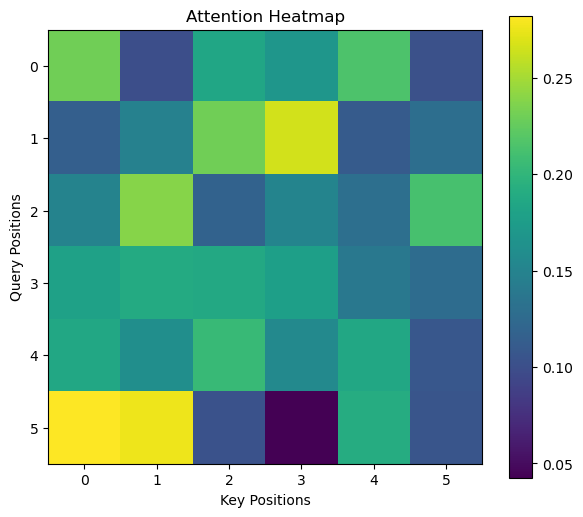


Tokens for sample sentence: ['the', 'cat', 'sat', 'on', 'the', 'mat']
Attention matrix shape: (6, 6)


In [19]:
head = 0     # pick one head
sample_idx = 0   # visualize attention for sentence 1

heatmap = attn_weights[sample_idx, head].detach().numpy()

plt.figure(figsize=(7,6))
plt.imshow(heatmap, cmap='viridis')
plt.colorbar()
plt.title("Attention Heatmap")
plt.xlabel("Key Positions")
plt.ylabel("Query Positions")
plt.show()

print("\nTokens for sample sentence:", tokens[sample_idx])
print("Attention matrix shape:", heatmap.shape)
